In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder


plt.rcParams["figure.figsize"] = (20,6)
rng = np.random.default_rng(51)

In [2]:
from sklearn.datasets import fetch_openml
# Загружаем датасет MNIST из OpenML (70000 примеров, 784 признака - это 28*28)
dmf = fetch_openml('mnist_784', version=1)

In [3]:
# 1. Загрузка данных
X, y = dmf["data"], dmf["target"]
# 3. Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Преобразование меток y в формат one-hot
encoder = OneHotEncoder(sparse_output=False)
y_one_hot = encoder.fit_transform(pd.DataFrame(y))
y_one_hot[y_one_hot == 0] = -1

X_scaled = X_scaled.reshape(-1, 1, 28, 28)

# 5. Разделение на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_one_hot, test_size=0.3, random_state=42)

y_train_class = encoder.inverse_transform(y_train)
y_test_class = encoder.inverse_transform(y_test)

In [4]:
from sklearn.manifold import TSNE

In [5]:
# tsne = TSNE(n_components=2, random_state=0)
# x_tsne = tsne.fit_transform(X_test.reshape((-1, 28 * 28)))

In [6]:
# # Визуализация результатов
# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_test_class, cmap='tab10', alpha=0.7)
# plt.colorbar(scatter, ticks=range(10), label="Цифры")
# plt.title("Визуализация MNIST с использованием t-SNE")
# plt.xlabel("t-SNE компонент 1")
# plt.ylabel("t-SNE компонент 2")
# plt.show()

# Модель

In [7]:
from NeuralNetwork import NeuralNetwork
from Functions import mse, dmse, Functions, rng
from LayerTypes import LayerTypes, create_layer

In [8]:
net_arch_mnist = ((20,5,5), (2,12,12), (10,3,3), (2, 5, 5), 20, 10)
NN = NeuralNetwork([
        create_layer(LayerTypes.CONVOLUTIONAL, kernel_count=net_arch_mnist[0][0],
                     kernel_size=(5, 5), input_size=(1, 28, 28),
                     activation_function=Functions.relu),
        create_layer(LayerTypes.POOLING, pool_size=2),
        create_layer(LayerTypes.CONVOLUTIONAL, kernel_count=net_arch_mnist[2][0],
                     kernel_size=(3, 3), input_size=(net_arch_mnist[0][0], 12, 12),
                     activation_function=Functions.relu),
        create_layer(LayerTypes.POOLING, pool_size=2),
        create_layer(LayerTypes.FLATTEN),
        create_layer(LayerTypes.DENSE, input_size=250, output_size=20, activation_function=Functions.tanh),
        create_layer(LayerTypes.DENSE, input_size=20, output_size=10, activation_function=Functions.tanh)
    ], 0.07)


In [9]:
loss = NN.fit(X_test, y_test, 3, batch_size=128)

100%|██████████| 3/3 [02:38<00:00, 52.92s/it]


In [10]:
loss

array([0.00199503, 0.00056992, 0.00035309])

In [11]:
class Metrics:

  def __init__(self, y_pred, y):
    self.confusion_matrix = self._init_confusion_matrix(y_pred, y)
    self.accuracy = np.trace(self.confusion_matrix) \
                    / np.sum(self.confusion_matrix)
    confusion_matrix = self.confusion_matrix
    # Инициализируем списки для precision, recall и F1 для каждого класса
    precision = []
    recall = []
    f1_score = []

    # Рассчитываем метрики для каждого класса
    for i in range(len(self.confusion_matrix)):
        TP = confusion_matrix[i, i]
        FP = np.sum(confusion_matrix[:, i]) - TP
        FN = np.sum(confusion_matrix[i, :]) - TP
        TN = np.sum(confusion_matrix) - (TP + FP + FN)

        # Precision, Recall, F1 для класса i
        prec = TP / (TP + FP) if (TP + FP) > 0 else 0
        rec = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0

        precision.append(prec)
        recall.append(rec)
        f1_score.append(f1)

        print(f"Class {i}: Precision = {prec:.4f}, Recall = {rec:.4f}, F1-Score = {f1:.4f}")
    self.precision = precision
    self.recall = recall
    self.f1_score = f1_score

  def _init_confusion_matrix(self, y_pred, y):
    n = max(np.max(y_pred), np.max(y)) + 1
    matrix = np.zeros((n, n))
    for i in range(len(y_pred)):
      pred_class = y_pred[i]
      class_label = y[i]
      matrix[pred_class, class_label] += 1
    return matrix

In [12]:
batch_size = 128
data = X_train[:10000]
y_data = y_train_class[:10000]
batch = data[0:batch_size]
res_proba = NN.forward(batch)
for i in range(batch_size, len(data), batch_size):
    batch = data[i:i+batch_size]
    res_batch = NN.forward(batch)
    res_proba = np.append(res_proba, res_batch, axis=0)
res_proba

array([[ 0.90893392, -0.99976455, -0.90797691, ..., -0.96603223,
        -0.99413877, -0.96637821],
       [-0.9999187 , -0.99505791, -0.99320904, ..., -0.94230952,
        -0.98058198, -0.99566493],
       [-0.99993673, -0.98347977, -0.9945292 , ..., -0.90680691,
        -0.99885871, -0.92577807],
       ...,
       [-0.99609397, -0.98385664, -0.95879816, ...,  0.93133726,
        -0.99707259, -0.87064136],
       [-0.99756118, -0.99698863, -0.999033  , ..., -0.9980074 ,
        -0.84610043, -0.85476884],
       [-0.87280843, -0.99766059, -0.97117611, ..., -0.99962049,
        -0.98074158, -0.99651892]])

['0']


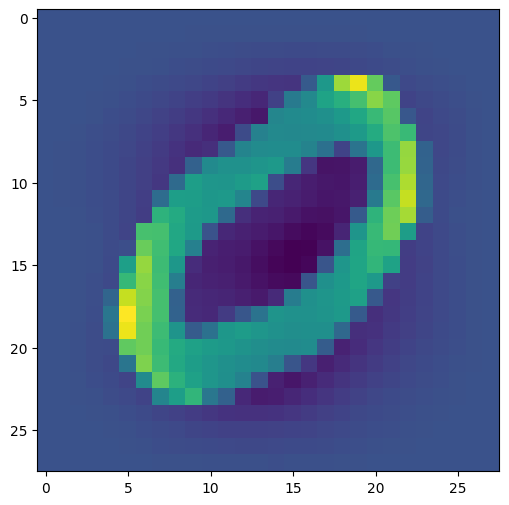

In [13]:
i = 0
plt.imshow(X_train[i].reshape(28, 28))
print((y_train_class[i]))

In [14]:
res_proba_max = res_proba.argmax(axis=1)
res_proba_max

array([0, 4, 4, ..., 7, 5, 6], dtype=int64)

In [15]:
y_data = y_data.astype(np.uint8)

In [16]:
y_train_class = y_train_class.astype(np.uint8)

In [17]:
metrics = Metrics(res_proba_max, y_data)
pd.DataFrame(metrics.confusion_matrix)

Class 0: Precision = 0.9560, Recall = 0.9560, F1-Score = 0.9560
Class 1: Precision = 0.9841, Recall = 0.9628, F1-Score = 0.9733
Class 2: Precision = 0.9083, Recall = 0.9459, F1-Score = 0.9267
Class 3: Precision = 0.8274, Recall = 0.9900, F1-Score = 0.9015
Class 4: Precision = 0.9416, Recall = 0.9493, F1-Score = 0.9455
Class 5: Precision = 0.9653, Recall = 0.8365, F1-Score = 0.8963
Class 6: Precision = 0.9590, Recall = 0.9355, F1-Score = 0.9471
Class 7: Precision = 0.9248, Recall = 0.9501, F1-Score = 0.9373
Class 8: Precision = 0.9313, Recall = 0.8841, F1-Score = 0.9071
Class 9: Precision = 0.9359, Recall = 0.9377, F1-Score = 0.9368


,0,1,2,3,4,5,6,7,8,9
0,955.0,0.0,7.0,3.0,2.0,2.0,16.0,2.0,4.0,8.0
1,0.0,1112.0,5.0,5.0,9.0,2.0,5.0,13.0,4.0,0.0
2,5.0,8.0,891.0,18.0,4.0,1.0,1.0,6.0,4.0,4.0
3,0.0,0.0,5.0,796.0,1.0,1.0,0.0,1.0,0.0,0.0
4,1.0,1.0,7.0,2.0,936.0,3.0,0.0,15.0,8.0,13.0
5,7.0,1.0,4.0,83.0,1.0,834.0,17.0,3.0,29.0,18.0
6,18.0,1.0,9.0,0.0,20.0,8.0,958.0,0.0,10.0,0.0
7,1.0,1.0,17.0,14.0,2.0,1.0,0.0,971.0,2.0,13.0
8,12.0,6.0,35.0,34.0,5.0,9.0,2.0,5.0,908.0,11.0
9,0.0,0.0,1.0,7.0,14.0,3.0,0.0,34.0,6.0,979.0


In [18]:
metrics.accuracy

0.934